# Ant Colony System for the TSP

In [ ]:
!rm -r AI2021MA/
!git clone https://github.com/UmbertoJr/AI2021MA.git &> /dev/null

In [ ]:
from AI2021MA.IO_manager.io_tsp import TSP_Instance_Creator
import numpy as np
from AI2021MA.solvers.local_search import twoOpt
from AI2021MA.solvers.constructive_algorithms import nn, compute_lenght
from AI2021MA.solvers.two_opt_with_candidate import twoOpt_with_cl
from time import time
from numpy.random import default_rng
from scipy.sparse import *
import pandas as pd
import matplotlib.pyplot as plt

name: d198
nPoints: 198
best_sol: 15780.0


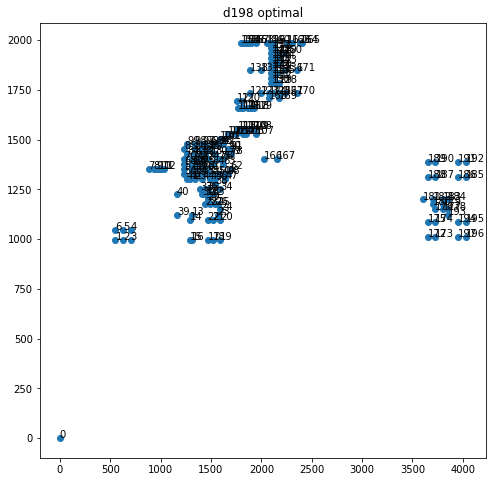

In [ ]:
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


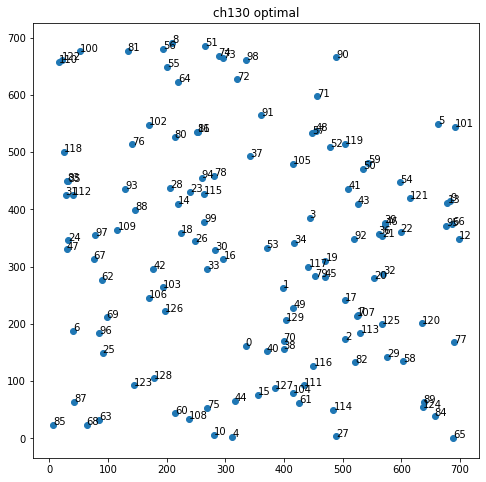

In [ ]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0


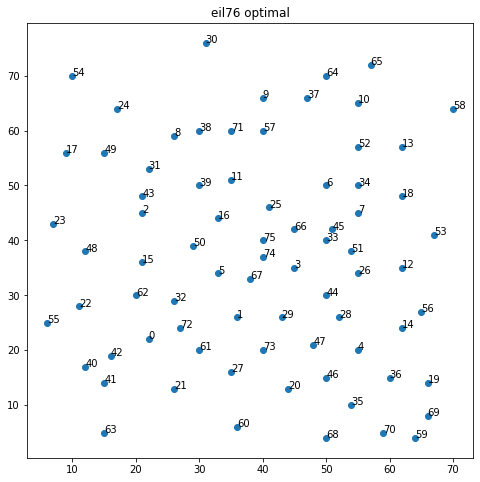

In [ ]:
ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

In [ ]:
# nn takes as input the distance matrix and returns 
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix 
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1

  @staticmethod
  def take_candidates(j, dist_mat, cl):
    return list(np.argsort(dist_mat[j])[1:cl+1])


  def __init__(self, instance, seed, q0, ca_li, twoopt):
    np.random.seed(seed)
    self.q0 = q0
    self.ca_li = ca_li
    self.epsilon = 0.000000000001
    self.twoopt = twoopt
    self.n = instance.nPoints
    self.cl = self.n-1 if not ca_li else 15
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps 
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants 
    self.pheromone = csr_matrix((self.n, self.n), dtype=np.float).toarray()
    for i in range(self.n):
      for j in range(self.n):
        self.pheromone[i][j] = self.tau0
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix, self.cl) for r in range(self.n)}
    self.eta = csr_matrix((instance.nPoints, instance.nPoints), dtype=np.float).toarray()
    for r in range(instance.nPoints):
      for s in range(instance.nPoints):
        if r != s:
          self.eta[r][s] = 1/self.dist_mat[r, s]
        else:
          self.eta[r][s] = self.epsilon
    self.len_tour = {a: 0 for a in range(ACS.m)}
    self.best_ant = -1
    self.best_tour = []
    self.best_len = -1
    self.global_best_ant = -1
    self.global_best_tour = []
    self.global_best_len = instance.best_sol**2


  # Initialize the class to start a new iteration
  def initialization(self):
      self.tour = {i: [] for i in range(ACS.m)}
      self.position = {i: None for i in range(ACS.m)}
      self.len_tour = {a: 0 for a in range(ACS.m)}
      self.best_ant = -1
      self.best_tour = []
      self.best_len = -1

      for ant in range(self.m):
        city = np.random.choice(self.n)
        self.position[ant] = city
        self.tour[ant].append(city)


  # Support Method
  def print_pheromone_tour(self, tour):
    forw = []
    back = []
    for i, _ in enumerate(tour):
      r = tour[i]
      s = tour[(i+1)%len(tour)]
      forw.append(self.pheromone[r][s])
      back.append(self.pheromone[s][r])
    print(f"Forw: {forw}")
    print(f"Back: {back}")


  # Support Method
  def print_state(self):
    print(f"Starting Positions: {self.position}")
    print(f"Tours: {self.tour}")
    #print(f"Pheromones: {self.pheromone}")
    #print(self.cl)
    #print(self.candidate_list)
    #print(self.pheromone[0])
    #print(self.eta[0])

  
  def global_update(self):
    Lbest = self.global_best_len
    best_tour = self.global_best_tour

    newpher = np.zeros([len(self.pheromone), len(self.pheromone)])

    for i, _ in enumerate(best_tour):
      r = best_tour[i]
      s = best_tour[(i+1)%len(best_tour)]
      newpher[r][s] = 1
      newpher[s][r] = 1

    self.pheromone = (1-ACS.alpha)*self.pheromone + (newpher*ACS.alpha*(1/Lbest))


  def local_update(self, r, s):
    self.pheromone[r][s] = (1-ACS.rho)*self.pheromone[r][s] + ACS.rho*self.tau0
    self.pheromone[s][r] = (1-ACS.rho)*self.pheromone[s][r] + ACS.rho*self.tau0


  def update_position(self, ant, r, s):
    self.position[ant] = s
    self.tour[ant].append(s)
    self.len_tour[ant] += self.dist_mat[r, s]
    self.local_update(r,s)

    if(len(self.tour[ant]) == self.n):
      self.len_tour[ant] += self.dist_mat[s, self.tour[ant][0]]
    #print(self.len_tour)


  def exploitation(self, ant):
    current_city = self.position[ant]
    
    # contains candidate cities
    cities = self.candidate_list[current_city]
    # contains dist from curr_city to candidate cities
    dist = self.eta[current_city]

    dist = np.power(dist, ACS.beta)
    pher = np.array(self.pheromone[current_city])

    prob_all = dist*pher
    prob_cand = dist*pher
    
    # Set to 0 the probability to go in a city which is not present in the candidate list
    if self.ca_li == True:
      for i in range(len(prob_cand)):
        if i not in cities:
          prob_cand[i] = 0

    next_city = np.argmax(prob_cand)
    
    while (next_city in self.tour[ant] and len(self.tour[ant]) < self.n):
      # choose a new city if candidate cities are all visited
      if (sum(prob_cand) == 0):
        next_city = np.argmax(prob_all)
        prob_all[next_city] = 0
      else:
        prob_cand[next_city] = 0
        next_city = np.argmax(prob_cand)

    self.update_position(ant, current_city, next_city)


  def exploration(self, ant):
    current_city = self.position[ant]
    
    cities = self.candidate_list[current_city]
    dist = self.eta[current_city]

    dist = np.power(dist, ACS.beta)
    pher = np.array(self.pheromone[current_city])


    prob_all = dist*pher
    prob_cand = dist*pher

    if self.ca_li == True:
      for i in range(len(prob_cand)):
        if i not in cities:
          prob_cand[i] = 0

    most_prob = np.argmax(prob_cand)
    prob_cand[most_prob] = 0

    den = sum(prob_cand)
    distrib = [val/den for val in prob_cand]
    cities = [val for val in range(self.n)]

    next_city = np.random.choice(cities, p=distrib)

    while (next_city in self.tour[ant] and len(self.tour[ant]) < self.n):
      if (sum(prob_cand) == 0):
        den = sum(prob_all)
        distrib = [val/den for val in prob_all]
        next_city = np.random.choice(cities, p=distrib)
        prob_all[next_city] = 0
      else:
        den = sum(prob_cand)
        distrib = [val/den for val in prob_cand]
        next_city = np.random.choice(cities, p=distrib)
        prob_cand[next_city] = 0
      

    self.update_position(ant, current_city, next_city)


  def set_best_ant(self):
    best_ant = min(self.len_tour, key=self.len_tour.get)
    self.best_ant = best_ant
    self.best_tour = self.tour[best_ant]
    self.best_len = self.len_tour[best_ant]
    return best_ant

  def set_global_best(self):
    if self.best_len < self.global_best_len:
      self.global_best_len = self.best_len
      self.global_best_tour = self.best_tour
      self.global_best_ant = self.best_ant

  def compute_twoopt(self, best_ant):
    tour, len_new = twoOpt_with_cl(self.best_tour, self.best_len, self.dist_mat, self.candidate_list)
    self.best_ant = best_ant
    self.best_len = np.float(len_new)
    self.best_tour = list(tour)



  # Method that compute a single Iteration 
  def run(self):
    self.initialization()
    # Use self.n-1 because you have to remove the city from where the ants start
    for city in range(self.n-1):
      for ant in range(self.m):
        q = np.random.rand()
        if q < self.q0:
          self.exploitation(ant)
        else:
          self.exploration(ant)
  
    best_ant = self.set_best_ant()

    if self.twoopt:
      self.compute_twoopt(best_ant)

    self.set_global_best()

    self.global_update()
    


In [ ]:
record = []
total_gaps = []
n = ic.nPoints
seed = [8657, 263, 90]
q0 = [0.5, 0.98, (1-13/n)]
ca_li = [True, False]
twoopt = True

print(f"Problem: {ic.name}")

for s in seed:
  for q in q0:
    for cl in ca_li:
      acs = ACS(ic, s, q, cl, twoopt)
      results = []
      global_bests = []
      iter = 0
      combination = f"Seed: {s}, q0: {np.around(q, 2)}, CL: {cl}, TO: True"
      print(f"> Testing: {combination}")

      # Compute a combination
      endtime = time() + 180
      while time() < endtime: 
        acs.run()
        iter += 1
        results.append([iter, acs.best_ant, acs.best_len, acs.best_tour])
        global_bests.append([iter, acs.global_best_ant, acs.global_best_len, acs.global_best_tour])
      if(acs.global_best_len == ic.best_sol):
        print(f"[+] Best Solution Found, in {best_cost_iter*acs.m}/{iter*acs.m}, Tour: {acs.global_best_tour}")
      
      # Results of a combination
      results = np.array(results)
      gba_idx = np.argmin(results[:, 2])
      stats = results[gba_idx]


      # Preparing Plot
      best_lengths_for_iters = results[:, 2]
      gaps = (((best_lengths_for_iters-ic.best_sol)/ic.best_sol)*100)
      total_gaps.append(gaps)


      ### Preparing Table data ###
      gap = (acs.global_best_len-ic.best_sol)/ic.best_sol
      best_cost = stats[2]
      best_cost_iter = stats[0]
      optim = ic.best_sol
      st_dev = np.std(np.array(global_bests)[:, 2])
      average = np.mean(np.array(global_bests)[:, 2])

      record.append([combination, best_cost, f"[{best_cost_iter*acs.m}/{iter*acs.m}]", average, st_dev, ic.best_sol, np.around(gap*100,2)])


x = np.min([len(gaps) for gaps in total_gaps])
plt.figure(figsize=(12,8))

for i in range(6):
  lst = np.array([total_gaps[i][:x], total_gaps[i+6][:x], total_gaps[i+12][:x]])
  y = np.mean(lst, axis=0)
  plt.plot(range(x), y, label=f"combination: {i}")

plt.legend()
plt.show()

# Print the table
res = pd.DataFrame(record, columns=["Combination", "Best Len", "Tours Generated", "Average", "STD", "Optim", "Relative Error"])
res

In [ ]:
# This cell allows to test a single combination in which you can specify the parameters

acs = ACS(ic, 42, 0.98, True, True)
results = []
global_bests = []
iter = 1
endtime = time() + 180
while time() < endtime:
#for count in range(1):
  acs.run()
  iter += 1
  print(f"{iter} - Best Tour > Ant: {acs.best_ant}, length: {acs.best_len}, tour: {acs.best_tour}")
  results.append([iter, acs.best_ant, acs.best_len, acs.best_tour])
  global_bests.append([iter, acs.global_best_ant, acs.global_best_len, acs.global_best_tour])


gap = np.abs(acs.global_best_len-ic.best_sol)/((acs.global_best_len + ic.best_sol)/2)
print(f"Gap: {np.around(gap*100,2)}%")
results = np.array(results)
gba_idx = np.argmin(results[:, 2])
stats = results[gba_idx]
print(f"Best cost: {stats[2]} in [{stats[0]}/{iter}] iterations")

In [ ]:
# This code allows to plot the results of the previous cell 

import matplotlib.pyplot as plt

global_bests = np.array(global_bests)
x = range(len(results[:, 1]))
y = results[:, 2]
y2 = global_bests[:, 2]


plt.figure(figsize=(12, 8))
plt.plot(x, y, '-', label="Iterations Bests")
plt.plot(x, y2, label="Global Bests")
plt.plot(x, [ic.best_sol]*(iter-1), label="Optimal solution")
plt.title(f"Seed: {seed}, q0: {q0}: CL: {ca_li}, TwoOpt: {twoopt} - Gap: {np.around(gap*100,2)}% - BS: {stats[2]}")
plt.legend()
plt.show()